The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [2]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-lwbdfu46
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-lwbdfu46
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 146 kB/s 
     |████████████████████████████████| 11.2 MB 61.4 MB/s 
     |████████████████████████████████| 61 kB 6.6 MB/s 
     |████████████████████████████████| 9.9 MB 40.4 MB/s 
     |████████████████████████████████| 930 kB 36.9 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=952423b50dc3d62818ce780f261f0d5364df255da71243a089f7028bda2dc85f
  Stored in directory: /tmp/pip-ephem-whe

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### Create Data
we will create our data here, ie. not using existing data.</br>
In this notebook, we are going to use Gradient Descent to optimize our Linear Regression for this 1000x2 size dataset </br>


**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

In [2]:
def synthetic_data(w,b,num_examples):
  """create y=Xw+b+noise"""
  X = torch.normal(0,1,(num_examples,len(w)))
  y = torch.matmul(X,w)+b
  y+= torch.normal(0,0.01,y.shape) #add noise
  return X,y.reshape((-1,1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note, X.shape would be (num_examples, 2), y.shape would be (num_examples, 1)


In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.0554, -0.1658]) 
label: tensor([2.6393])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系。


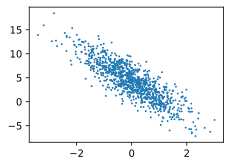

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## Read Data

We will use mini-batch to help our learning speed. We will define function `data_iter` to help us shuffle and sample each batch. </br>
The input : batch_size, features, labels </br>
No output, it will yield samples with defined `batch_size`



In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.0248,  0.4066],
        [-1.0272,  2.3459],
        [ 0.2491,  2.4144],
        [-1.9072, -1.1440],
        [-0.5959, -1.4903],
        [ 0.5929, -0.5850],
        [ 0.1985,  0.2934],
        [-1.0662, -0.1883],
        [-0.7843,  0.5119],
        [-0.8447, -0.3893]]) 
 tensor([[ 2.7745],
        [-5.8248],
        [-3.5050],
        [ 4.2644],
        [ 8.0870],
        [ 7.3687],
        [ 3.5844],
        [ 2.7236],
        [ 0.8811],
        [ 3.8364]])


When we deal with mini-batch, with large dataset, we need to loop through the whole data to sample out each batch, and when we try to store the batches in our GPU, it may cause problems. So it's important for us to use some Deep Learning Frameworks to deal with such problems.
## Initilization

Initialize W to be standardized normal distributed , b to be zeros


In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) #requires_grad = True is an indicator to record gradients on a tensor.
b = torch.zeros(1, requires_grad=True)


we use :numref:`sec_autograd`to calculate gradient

## Define Model


In [10]:
def linreg(X, w, b):  
    """Linear Regression"""
    return torch.matmul(X, w) + b

## **Calculate Loss**



In [13]:
def squared_loss(y_hat, y):  
    """MSE"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 #convert y to the same shape as y hat

## (**Optimization**)


In [15]:
def sgd(params, lr, batch_size): 
    """mini batch GD"""
    with torch.no_grad(): #Torch.no_grad() deactivates autograd engine. Eventually it will reduce the memory usage and speed up computations.
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training



In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [17]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # calculate loss for this batch
        l.sum().backward() #calculate gradients
        sgd([w, b], lr, batch_size)  # update gradients
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046937
epoch 2, loss 0.000195
epoch 3, loss 0.000048


Let's check the difference between the true parameters and predicted parameters


In [18]:
print(f'w difference: {true_w - w.reshape(true_w.shape)}')
print(f'b difference: {true_b - b}')

w difference: tensor([ 0.0002, -0.0006], grad_fn=<SubBackward0>)
b difference: tensor([0.0008], grad_fn=<RsubBackward1>)
